<a href="https://colab.research.google.com/github/negiamishhu/Skin-disease-detection-using-CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: gdrive mount code

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Skin cancer lesion classification using the HAM10000 dataset

Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description:
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc)
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [ ]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

In [ ]:
import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [ ]:
skin_df = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')

In [ ]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

<ipython-input-8-4fab013ef28c>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


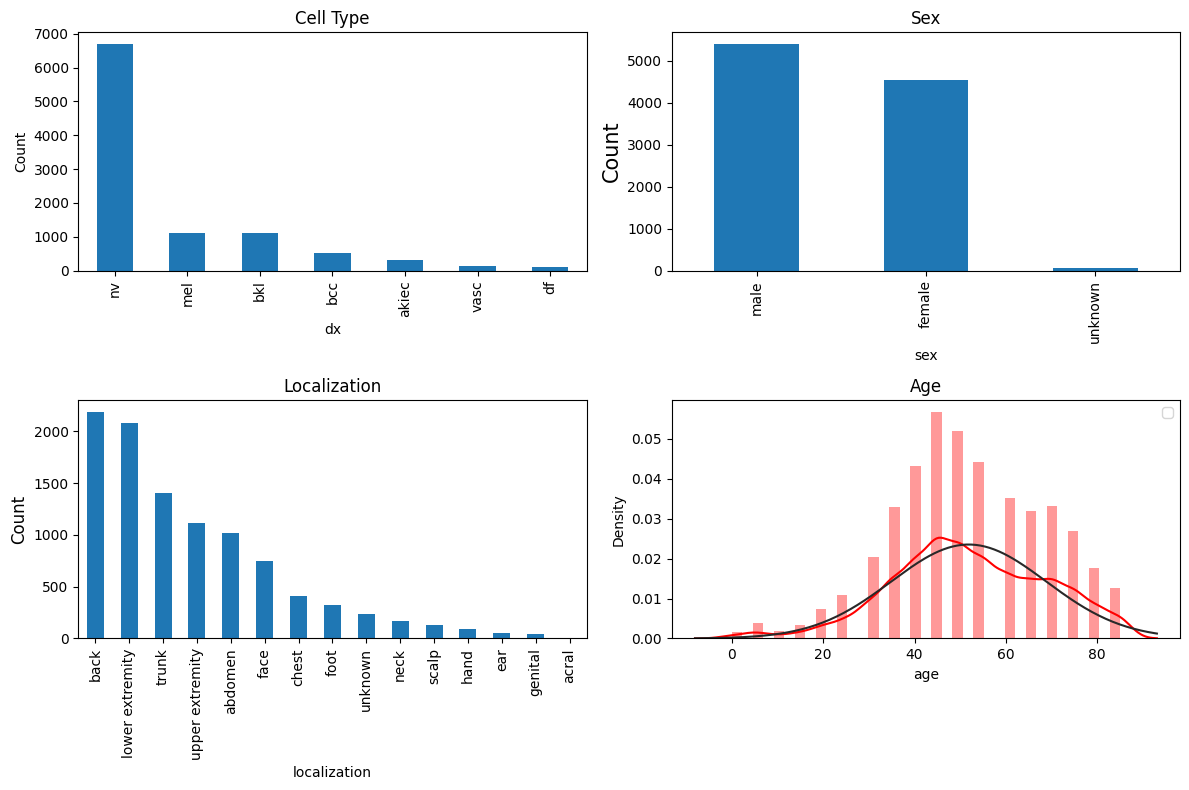

In [ ]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# Distribution of data into various classes
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [ ]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [ ]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [ ]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [ ]:
!cp /content/drive/MyDrive/HAM10000.zip /content/
!cp /content/drive/MyDrive/HAM10000_images_part_2.zip /content

In [ ]:
!unzip /content/HAM10000.zip
!unzip /content/HAM10000_images_part_2.zip

Streaming output truncated to the last 5000 lines.
  inflating: HAM10000_images_part_2/ISIC_0029321.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029322.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029323.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029324.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029325.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029326.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029327.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029328.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029329.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029330.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029331.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029332.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029333.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029334.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029335.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029336.jpg  
  inflating: HAM10000_images_part_2/ISIC_0029337.jpg  
  inflating: H

In [ ]:
!cp /content/HAM10000 /content/
!cp -r /content/HAM10000_images_part_2/* /content/HAM10000/

cp: -r not specified; omitting directory '/content/HAM10000'


In [ ]:
# prompt: Generate code to create image_path dictionary with Image id as key

# Create an empty dictionary to store image paths
image_path = {}

# Iterate over the skin_df_balanced dataframe
for index, row in skin_df_balanced.iterrows():
    # Get the image ID from the 'image_id' column
    image_id = row['image_id']

    # Construct the image path using the 'image_id' and the path to the HAM10000 dataset
    image_path[image_id] = os.path.join('HAM10000/', image_id + '.jpg')

In [ ]:
image_path['ISIC_0032981']

'HAM10000/ISIC_0032981.jpg'

In [ ]:
!pip install Pillow

In [ ]:
#Define the path and add as a new column
for image_id in skin_df_balanced['image_id']:
    path = image_path.get(image_id)
    if path is None:
        print(f"Image ID {image_id} has a None path.")

skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

n_samples = 5  # number of samples for plotting

In [ ]:
print(skin_df_balanced.sample(10))

        lesion_id      image_id     dx    dx_type   age     sex  \
2379  HAM_0001852  ISIC_0033749   vasc      histo  80.0    male   
9919  HAM_0006442  ISIC_0033000  akiec      histo  70.0    male   
2347  HAM_0007614  ISIC_0027672   vasc      histo  55.0  female   
2387  HAM_0004820  ISIC_0030722   vasc  consensus  45.0  female   
1153  HAM_0007418  ISIC_0026313     df  consensus  50.0    male   
704   HAM_0004630  ISIC_0028376    bkl      histo  85.0    male   
90    HAM_0002921  ISIC_0029308    bkl      histo  60.0  female   
955   HAM_0000332  ISIC_0033784    bkl  consensus  80.0  female   
9730  HAM_0006222  ISIC_0025069  akiec      histo  75.0    male   
8843  HAM_0006685  ISIC_0025542     nv      histo  20.0  female   

         localization  label                       path  \
2379  lower extremity      6  HAM10000/ISIC_0033749.jpg   
9919             hand      0  HAM10000/ISIC_0033000.jpg   
2347             face      6  HAM10000/ISIC_0027672.jpg   
2387          abdomen     

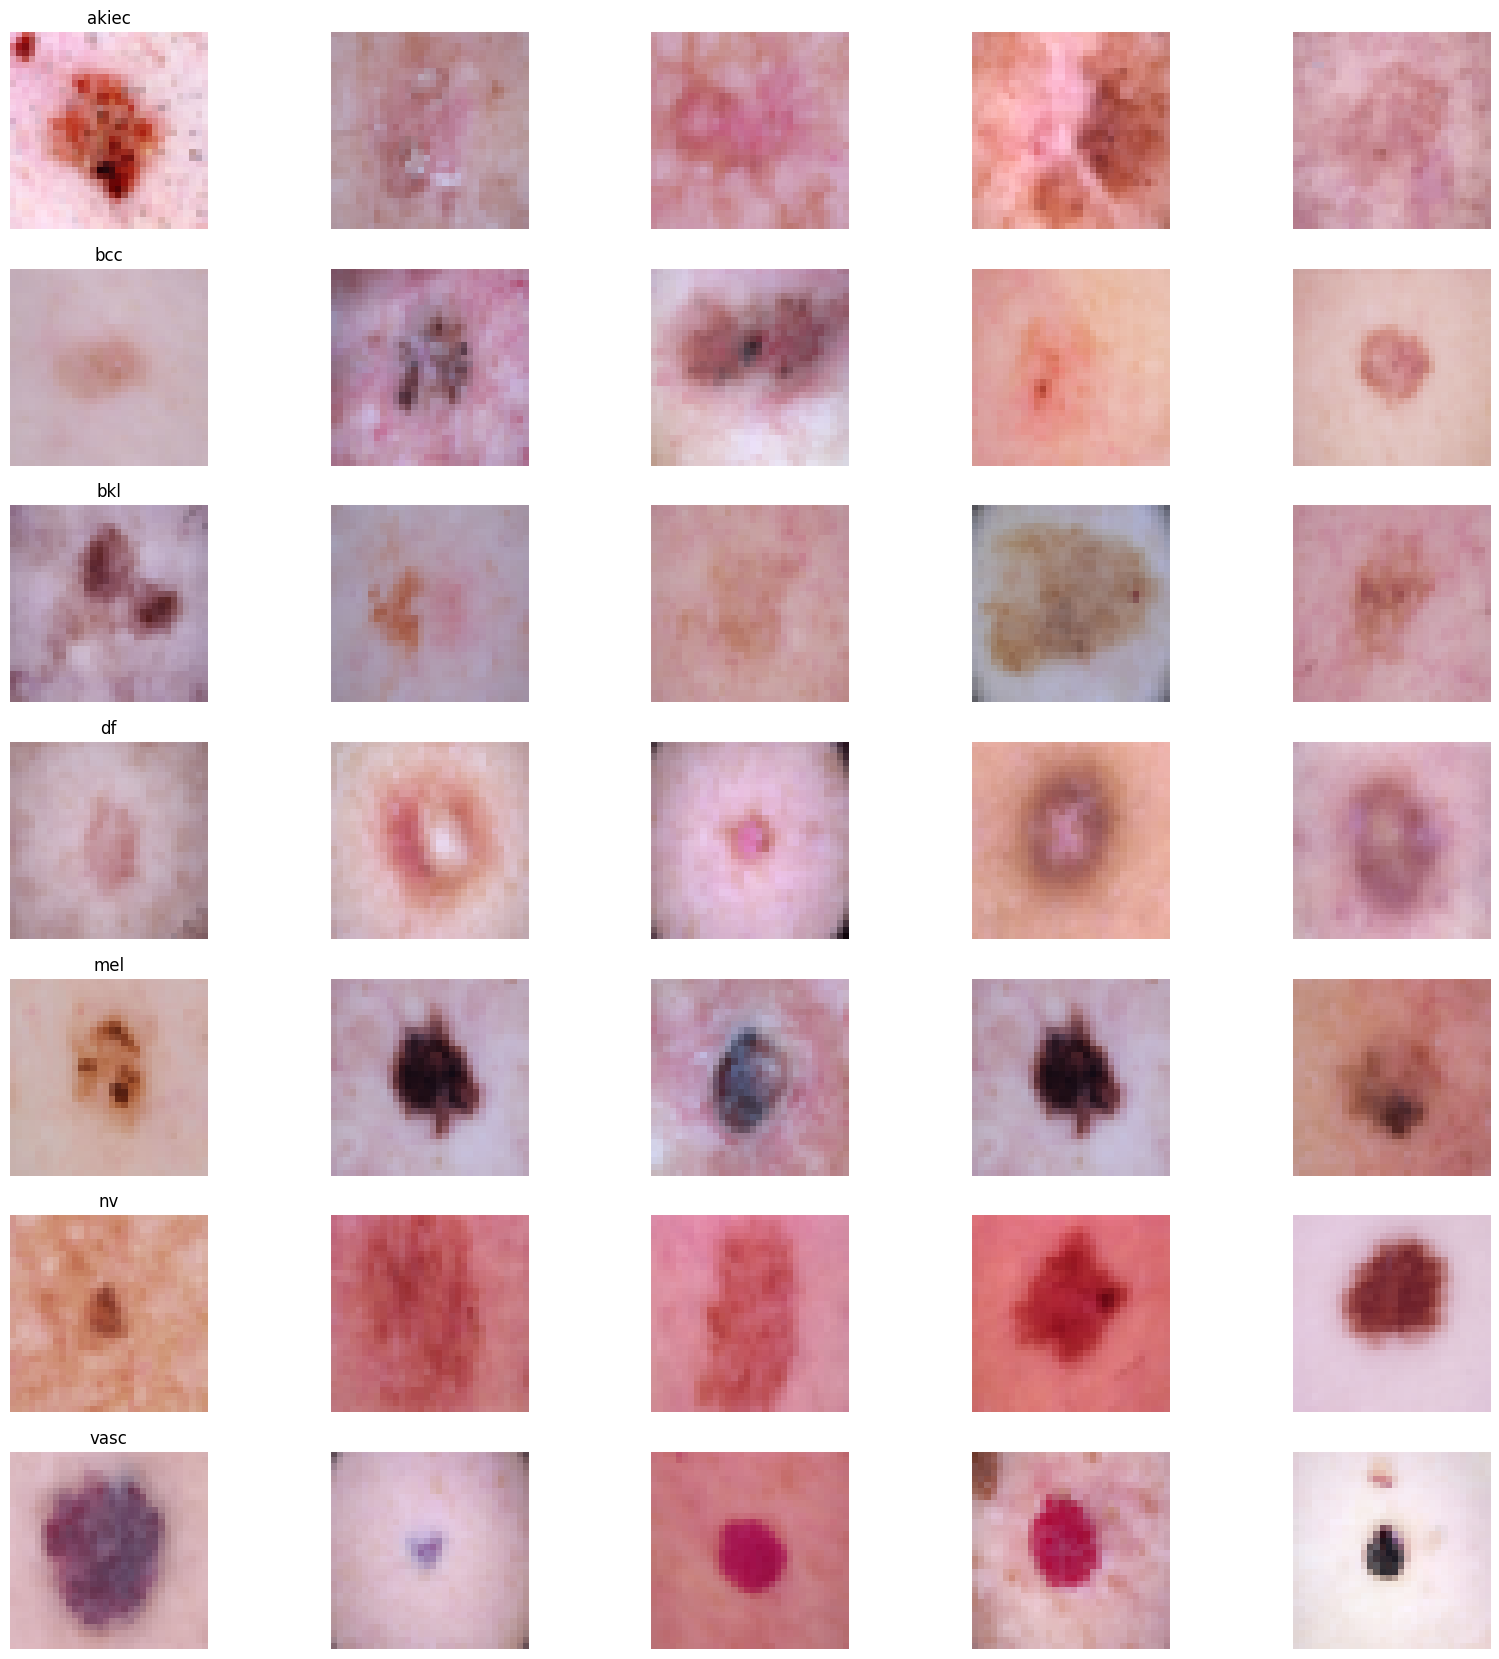

In [ ]:
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [ ]:
x_train.shape

(2625, 32, 32, 3)

In [ ]:
x_test.shape

(875, 32, 32, 3)

In [ ]:
y_train.shape

(2625, 7)

In [ ]:
y_test.shape

(875, 7)

In [ ]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(32, 32, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [ ]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16
epochs = 50

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/50
165/165 - 66s - loss: 1.8814 - acc: 0.1939 - val_loss: 1.7886 - val_acc: 0.2583 - 66s/epoch - 399ms/step
Epoch 2/50
165/165 - 32s - loss: 1.7089 - acc: 0.2914 - val_loss: 1.6110 - val_acc: 0.3406 - 32s/epoch - 196ms/step
Epoch 3/50
165/165 - 38s - loss: 1.5111 - acc: 0.3787 - val_loss: 1.4432 - val_acc: 0.4183 - 38s/epoch - 229ms/step
Epoch 4/50
165/165 - 35s - loss: 1.4528 - acc: 0.4107 - val_loss: 1.4314 - val_acc: 0.4297 - 35s/epoch - 213ms/step
Epoch 5/50
165/165 - 35s - loss: 1.3936 - acc: 0.4457 - val_loss: 1.3555 - val_acc: 0.4480 - 35s/epoch - 214ms/step
Epoch 6/50
165/165 - 39s - loss: 1.3588 - acc: 0.4686 - val_loss: 1.4231 - val_acc: 0.4149 - 39s/epoch - 234ms/step
Epoch 7/50
165/165 - 34s - loss: 1.3351 - acc: 0.4644 - val_loss: 1.3449 - val_acc: 0.4331 - 34s/epoch - 209ms/step
Epoch 8/50
165/165 - 37s - loss: 1.3087 - acc: 0.4750 - val_loss: 1.2848 - val_acc: 0.4663 - 37s/epoch - 222ms/step
Epoch 9/50
165/165 - 32s - loss: 1.2639 - acc: 0.5036 - val_loss: 1.3115

In [ ]:
# Evaluate the model on the test set and print accuracy
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 4s 156ms/step - loss: 0.8407 - acc: 0.7006
Test accuracy: 0.7005714178085327


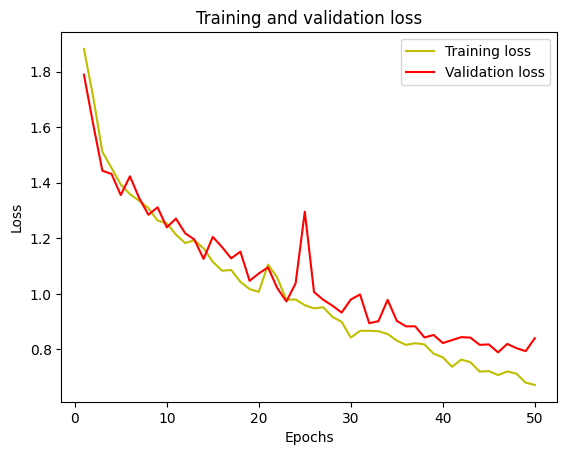

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

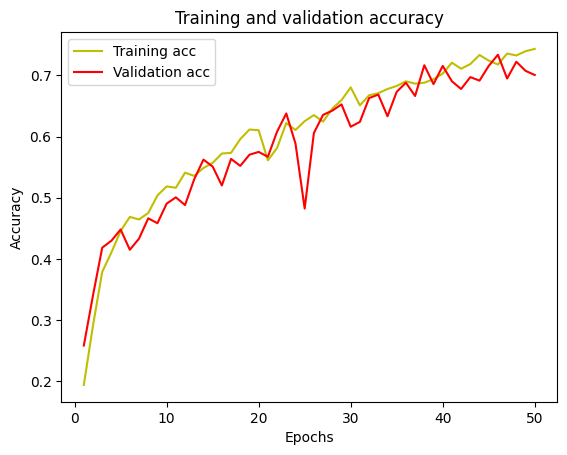

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

28/28 [==============================] - 2s 71ms/step


<Axes: >

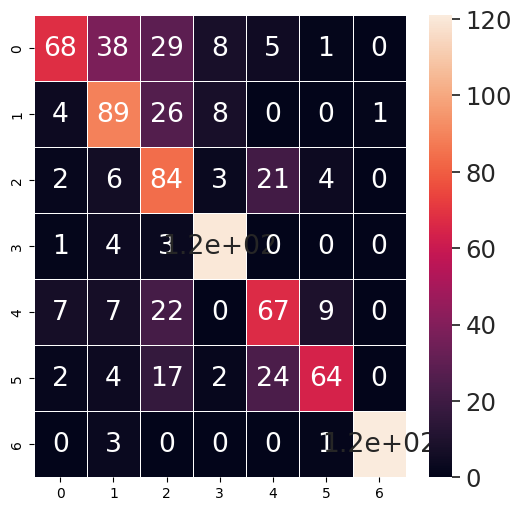

In [ ]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

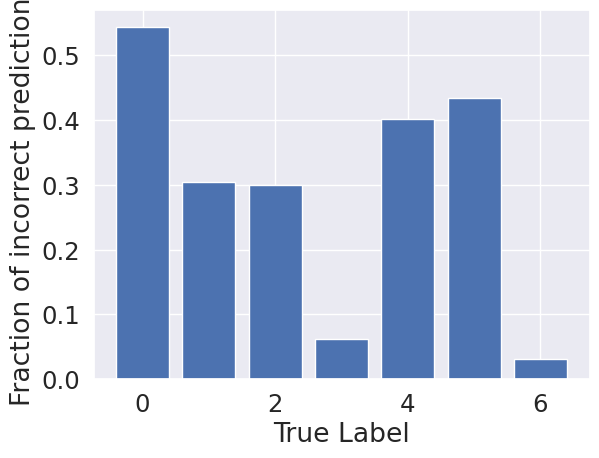

In [ ]:
#Plot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [ ]:
from tensorflow.keras.models import load_model
model.save('')